In [12]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [4]:
datasets = [
    "mendelian_matched_9",
    "gwas_matched_9",
]

subsets = [
    "nonexonic_AND_distal",
    "nonexonic_AND_proximal",
    "5_prime_UTR_variant",
    "3_prime_UTR_variant",
    "non_coding_transcript_exon_variant",
]

modalities = [
    "Zero-shot",
]

models = [
    "CADD",
    "GPN-MSA",
    "GPN",
    "Enformer",
    "Borzoi",
]

def get_model_path(model, modality, dataset, subset):
    supervised_suffix = "LogisticRegression.chrom"
    if model == "CADD":
        predictor = "CADD.plus.RawScore" if modality == "Zero-shot" else f"CADD.{supervised_suffix}"
    elif model in ["Enformer", "Borzoi"]:
        predictor = f"{model}_L2_L2.plus.all" if modality == "Zero-shot" else f"{model}.{supervised_suffix}"
    elif model == "Ensemble":
        if "mendelian" in dataset:
            prefix = "OMIM_Ensemble_v2" 
        else:
            prefix = "Enformer+GPN-MSA+CADD"
        predictor = f"{prefix}.{supervised_suffix}"
    else:
        if "mendelian" in dataset:
            llr_version = "LLR"
            sign = "minus"
        elif "gwas" in dataset:
            llr_version = "absLLR"
            sign = "plus"
        predictor = f"{model}_{llr_version}.{sign}.score" if modality == "Zero-shot" else f"{model}_{llr_version}+InnerProducts.{supervised_suffix}"
    return f"../../results/dataset/{dataset}/metrics/{subset}/{predictor}.csv"

In [5]:
rows = []
for dataset in datasets:
    for subset in subsets:
        for modality in modalities:
            for model in models:
                if model == "Ensemble" and modality == "Zero-shot":
                    continue
                path = get_model_path(model, modality, dataset, subset)
                df = pd.read_csv(path).iloc[0]
                rows.append([dataset, subset, modality, model, df["score"], df["se"]])
df = pd.DataFrame(rows, columns=["dataset", "subset", "modality", "model", "score", "se"])
df

,dataset,subset,modality,model,score,se
0,mendelian_matched_9,nonexonic_AND_distal,Zero-shot,CADD,0.733494,0.100880
1,mendelian_matched_9,nonexonic_AND_distal,Zero-shot,GPN-MSA,0.801788,0.111423
2,mendelian_matched_9,nonexonic_AND_distal,Zero-shot,GPN,0.118537,0.033912
3,mendelian_matched_9,nonexonic_AND_distal,Zero-shot,Enformer,0.278975,0.115707
4,mendelian_matched_9,nonexonic_AND_distal,Zero-shot,Borzoi,0.264822,0.109293
5,mendelian_matched_9,nonexonic_AND_proximal,Zero-shot,CADD,0.696963,0.041834
6,mendelian_matched_9,nonexonic_AND_proximal,Zero-shot,GPN-MSA,0.659172,0.045563
7,mendelian_matched_9,nonexonic_AND_proximal,Zero-shot,GPN,0.309172,0.042878
8,mendelian_matched_9,nonexonic_AND_proximal,Zero-shot,Enformer,0.534044,0.078623
9,mendelian_matched_9,nonexonic_AND_proximal,Zero-shot,Borzoi,0.601683,0.096110


In [6]:
df.dataset = df.dataset.map({
    "mendelian_matched_9": "Mendelian traits",
    "gwas_matched_9": "Complex traits",
})
df.subset = df.subset.map({
    "nonexonic_AND_distal": "Non-exonic (distal)",
    "nonexonic_AND_proximal": "Non-exonic (proximal)",
    "5_prime_UTR_variant": "5' UTR",
    "3_prime_UTR_variant": "3' UTR",
    "non_coding_transcript_exon_variant": "ncRNA",
})

/scratch/users/gbenegas/software/mambaforge/envs/gpn/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/scratch/users/gbenegas/software/mambaforge/envs/gpn/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/scratch/users/gbenegas/software/mambaforge/envs/gpn/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/scratch/users/gbenegas/software/mambaforge/envs/gpn/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureW

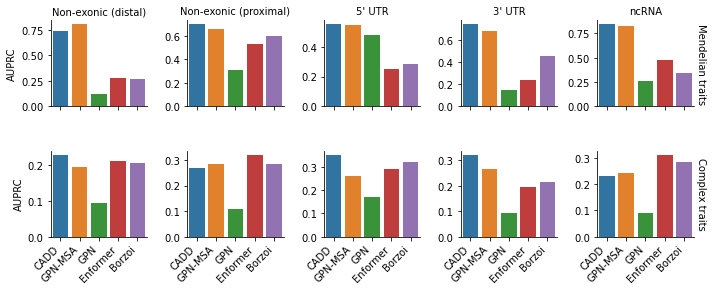

In [37]:
# TODO: add error bars

g = sns.catplot(
    data=df.rename(columns={"score": "AUPRC"}),
    x="model",
    y="AUPRC",
    row="dataset",
    col="subset",
    kind="bar",
    sharey=False,
    margin_titles=True,
    height=2,
)
g.set(
    xlabel="",
)
for ax in g.axes[-1, :]:  # Select only the last row
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
g.set_titles(col_template="{col_name}", row_template="{row_name}");